##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [189]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn


In [190]:
orig_df = pd.read_csv('datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [191]:
df = pd.read_csv('datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [192]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [193]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [194]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [195]:
print("Max Area Command:", max(df.Area_Command))
print("Max Victim Count:", max(df.VictimCount))
print("Max NIBRSOffenseCode:", max(df.NIBRSOffenseCode))
print("Max TimeOfDay:", max(df['Time']))
print("Max DayOfWeek:", max(df['DayOfWeek']))
df.head(10)
# df

Max Area Command: 11
Max Victim Count: 6
Max NIBRSOffenseCode: 2
Max TimeOfDay: 23
Max DayOfWeek: 6


,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0
5,-115.132162,36.100841,5,1,3,4,1
6,-115.176012,36.194067,1,1,4,5,2
7,-115.194061,36.135213,3,1,4,3,1
8,-115.069716,36.191304,0,1,5,6,0
9,-115.309341,36.074367,6,1,6,1,0


# Each Column
X, Y = Longitude and Latitude coords respectively

Area_Command = who responded

NIBRSOffenseCode = Classification code for the crime commited

DayOfWeek = What day of the week it was (E.g. Monday = 1, Sunday = 0) # Double check this

Time = Hour it happened

VictimCount = # of victims for that crime



# Input and Output Variables
Input: X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time

Output: VictimCount

# What are the ranges, and do we need to scale, shift, or normalize our data?
As far as I can tell, the ranges extend from 0-23 max, and that represents the time of day. The other input variables classify specific things like the Area Command location, the offense code, and what day it happened, so we wouldn't want to scale those values because we want to keep it true.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [196]:
# class MyDataset(Dataset):
#     def __init__(self, df):
#         self.df = df
        
#     def __getitem__(self, idx):
#         # Return a single data point from the dataset
#         return self.df.iloc[idx]
    
# train_dataset = MyDataset(df)
# test_dataset = MyDataset(df)
# print(train_dataset.__getitem__(5))

In [197]:
df.values.shape

(275, 7)

In [198]:
batch_size = 25
n_iters = 3000

# Take some row from 275 into train, and some into test. Smol amount for test.
X_train = torch.Tensor(df.iloc[0:200, 0:6].values) # Row 0 - 199, Col 0 - 5
Y_train = torch.Tensor(df.iloc[0:200, 6].values) # Row 0 - 199, Col 6

X_test = torch.Tensor(df.iloc[200:275, 0:6].values) # Row 200 - 274, Col 0 - 5
Y_test = torch.Tensor(df.iloc[200:275, 6].values) # Row 200 - 274, Col 6

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(np.ceil(num_epochs))

train_loader = DataLoader(dataset=train_dataset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        drop_last=True)

test_loader = DataLoader(dataset=test_dataset, 
                        batch_size=batch_size, 
                        shuffle=False,
                        drop_last=True)


In [199]:
print(X_train[2])
print(Y_train[2])

print("Train:", X_train.shape, Y_train.shape)
print("Test:", X_test.shape, Y_test.shape)

tensor([-115.1431,   36.1813,    2.0000,    1.0000,    2.0000,    0.0000])
tensor(1.)
Train: torch.Size([200, 6]) torch.Size([200])
Test: torch.Size([75, 6]) torch.Size([75])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [200]:
for i, (images, labels) in enumerate(train_loader):
    print(i)
    print(images.shape)
    print(labels.shape)
    break

0
torch.Size([25, 6])
torch.Size([25])


In [201]:
# Predict a real number between 0.00 - 6.00
for i,d in enumerate(train_loader):
    x, y = d
    print(y)
    break
for x, y in train_loader:
    print(x.shape, y.shape)
    break

tensor([1., 2., 1., 3., 0., 1., 1., 1., 1., 3., 1., 0., 0., 0., 3., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 1.])
torch.Size([25, 6]) torch.Size([25])


In [202]:
# Loss_function should be MSE here?
loss_function = nn.MSELoss()
# loss_function = nn.CrossEntropyLoss()

In [203]:
# Input dim should be (batch_size, 6)
# Output dim should be (batch_size, 1)
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()

        # Non-linearity
        self.activation = nn.Sigmoid() # Sigmoid for regression? Softmax for Multiclass Classifcation?
        # Create a new activation here with Relu for positive numbers only on last layer
        self.activation_relu = nn.ReLU()
        
        # Input Layer 
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        
        # Hidden Layer 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) 
        
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)

        # Output Layer 
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h1 = self.activation(self.fc1(x))
        h2 = self.activation(self.fc2(h1))
        h3 = self.activation(self.fc4(h2))
        final = h3
        out = self.activation_relu(self.fc3(final)) # Use different activation here
        return out

In [204]:
# Activation should be Sigmoid here?
model = FFNN(6, 50, 1) # 6 input dimension, 50 hidden layer dimension, 1 output dimension
model

FFNN(
  (activation): Sigmoid()
  (activation_relu): ReLU()
  (fc1): Linear(in_features=6, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)

In [205]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [206]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(batch_size, -1).requires_grad_() # Does .view just flip the dimensions?
        # print("image shape:", images.shape)
        # images.reshape(images.shape)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        prediction = model(images) # [40, 10] for 40 batch size, 10 numbers
        # prediction = prediction.squeeze() # Turns it from (batch, 1) -> (batch)
        # print("prediction shape:", prediction.shape)
        # print("labels shape:", labels.shape)
        # print(prediction[i])
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(prediction, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        # Every 500 iterations
        if iter % 500 == 0:
            images = images.view(batch_size, -1).requires_grad_()
            # print(images.shape, labels.shape)
            
            # Forward pass only to get logits/output
            outputs = model(images) # Only printing 1s?
            
            # Get predictions
            predicted = outputs.data
            
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                mse = loss_function(labels, prediction)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. MSE: {}'.format(iter, loss.item(), mse))
print("Regression Prediction:", prediction.squeeze())

/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 500. Loss: 0.5126314163208008. MSE: 1.7101861238479614
Iteration: 1000. Loss: 0.7661256194114685. MSE: 1.732944130897522
Iteration: 1500. Loss: 0.26911553740501404. MSE: 1.7124605178833008
Iteration: 2000. Loss: 0.5494588613510132. MSE: 1.707145094871521
Iteration: 2500. Loss: 0.9742939472198486. MSE: 1.7225908041000366
Iteration: 3000. Loss: 0.5674101710319519. MSE: 1.714199185371399
Regression Prediction: tensor([0.6514, 0.6514, 0.6514, 0.6514, 0.6514, 0.6514, 0.6514, 0.6514, 0.6514,
        0.6514, 0.6514, 0.6514, 0.6514, 0.6514, 0.6514, 0.6514, 0.6514, 0.6514,
        0.6514, 0.6514, 0.6514, 0.6514, 0.6514, 0.6514, 0.6514],
       grad_fn=<SqueezeBackward0>)


## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [207]:
# Predict a whole number between 0 - 6
for i,d in enumerate(train_loader):
    x, y = d
    print(y)
    break
for x, y in train_loader:
    print(x.shape, y.shape)
    break
for i, d in enumerate(test_loader):
    x, y = d
    print(y)

tensor([1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 0., 1., 0., 1., 0.])
torch.Size([25, 6]) torch.Size([25])
tensor([3., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 3., 0., 3., 0., 0., 3., 3.,
        1., 3., 3., 1., 3., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 2., 2.,
        0., 1., 0., 5., 1., 1., 1.])
tensor([0., 0., 0., 0., 0., 6., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
        3., 1., 0., 0., 2., 0., 1.])


In [208]:
loss_function = nn.CrossEntropyLoss()

In [209]:
# Input dim should be (batch_size, 6)
# Output dim should be (batch_size, 1)
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()

        # Non-linearity
        self.activation = nn.Softmax(dim=-1) # Sigmoid for regression? Softmax for Multiclass Classifcation?
        # Create a new activation here with Relu for positive numbers only on last layer
        self.activation_relu = nn.ReLU()
        
        # Input Layer 
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        
        # Hidden Layer 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) 
        
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)

        # Output Layer 
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h1 = self.activation_relu(self.fc1(x))
        h2 = self.activation_relu(self.fc2(h1))
        h3 = self.activation_relu(self.fc4(h2))
        final = h3
        out = self.activation(self.fc3(final)) # Softmax activation on output for classification problems?
        return out

In [210]:
# Activation should be Softmax here?
model = FFNN(6, 50, 7) # 6 input dimension, 50 hidden layer dimension, 1 output dimension
model

FFNN(
  (activation): Softmax(dim=-1)
  (activation_relu): ReLU()
  (fc1): Linear(in_features=6, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=7, bias=True)
)

In [211]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [212]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(batch_size, -1).requires_grad_()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        # Forward pass to get output/logits
        prediction = model(images)
        prediction = prediction.squeeze() # Changes from (batch_size, 1) -> (batch_size)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(prediction, labels.long())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        # Every 500 iterations
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images with gradient accumulation capabilities
                images = images.view(batch_size, -1).requires_grad_()
                # print(images.shape, labels.shape)
                
                # Forward pass only to get logits/output
                outputs = model(images) # Only printing 1s?
                
                # Get predictions
                _,predicted = torch.max(outputs.data, dim=1)
                
                # Reshape either predicted or labels into the other
                # predicted = predicted.view(1, -1)
                 
                # Total number of labels
                total += labels.size(0)
                # Total correct predictions
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print("Classification Predictions:", predicted)

Iteration: 500. Loss: 1.8454222679138184. Accuracy: 49.33333206176758
Iteration: 1000. Loss: 1.5654220581054688. Accuracy: 49.33333206176758
Iteration: 1500. Loss: 1.4854220151901245. Accuracy: 49.33333206176758
Iteration: 2000. Loss: 1.6054222583770752. Accuracy: 49.33333206176758
Iteration: 2500. Loss: 1.5654221773147583. Accuracy: 49.33333206176758
Iteration: 3000. Loss: 1.7254222631454468. Accuracy: 49.33333206176758
Classification Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

My experience with tasks 3 and 4 were **PAINFUL**. I compared the results by looking at one prediction array from each and checking the ranges of predictions. It's hard to say which one works better because they have different use cases, but if I had to pick one, I would say the Regression model because it predicted mostly 0.00 - 1.00, which makes sense since most of the victims fell between those numbers, compared to our Classifcation model, which either printed all 0s or all 1s in my case. On average, my Regression model was predicting 0.6752 victims, which I feel is more information than predicting 0 victims constantly. 

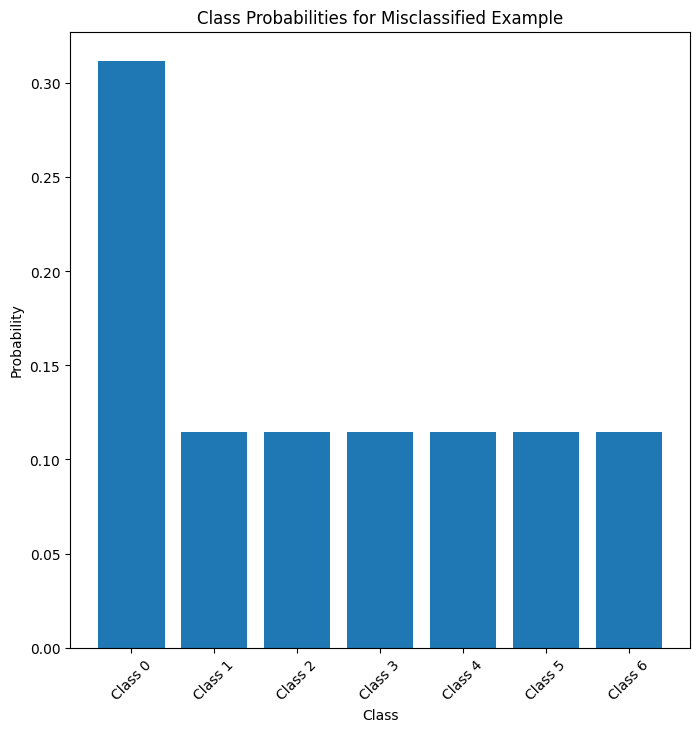

Misclassified Example Index: 0
Correct Class Label: 3.0
Predicted Class[0] Probabilities: 0.31
Predicted Class[1] Probabilities: 0.11
Predicted Class[2] Probabilities: 0.11
Predicted Class[3] Probabilities: 0.11
Predicted Class[4] Probabilities: 0.11
Predicted Class[5] Probabilities: 0.11
Predicted Class[6] Probabilities: 0.11


In [213]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        prediction = model(images)
        loss = loss_function(prediction, labels.long())
        loss.backward()
        optimizer.step()

# Find a misclassified example and calculate probabilities
misclassified_idx = -1  # Initialize with an invalid index

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, dim=1)  # Get the class with the highest probability

        misclassified = (predicted != labels)
        misclassified_idx = misclassified.nonzero()

        if misclassified_idx.numel() > 0:
            misclassified_idx = misclassified_idx[0].item()  # Get the first misclassified example
            break

# Get the correct class label for the misclassified example
correct_class_label = Y_test[misclassified_idx].item()

# Get the predicted class probabilities
probs = torch.softmax(outputs[misclassified_idx], dim=0).tolist()

# Plot the predicted probabilities in a bar chart
class_names = [f"Class {i}" for i in range(7)]  # Modify as needed based on your classes

plt.figure(figsize=(8, 8))
plt.bar(class_names, probs)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Class Probabilities for Misclassified Example')
plt.xticks(rotation=45)
plt.show()

print(f"Misclassified Example Index: {misclassified_idx}")
print(f"Correct Class Label: {correct_class_label}")
probability = [f"Predicted Class[{i}] Probabilities: {probs[i]:.2f}" for i in range(7)]
print('\n'.join(probability))

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


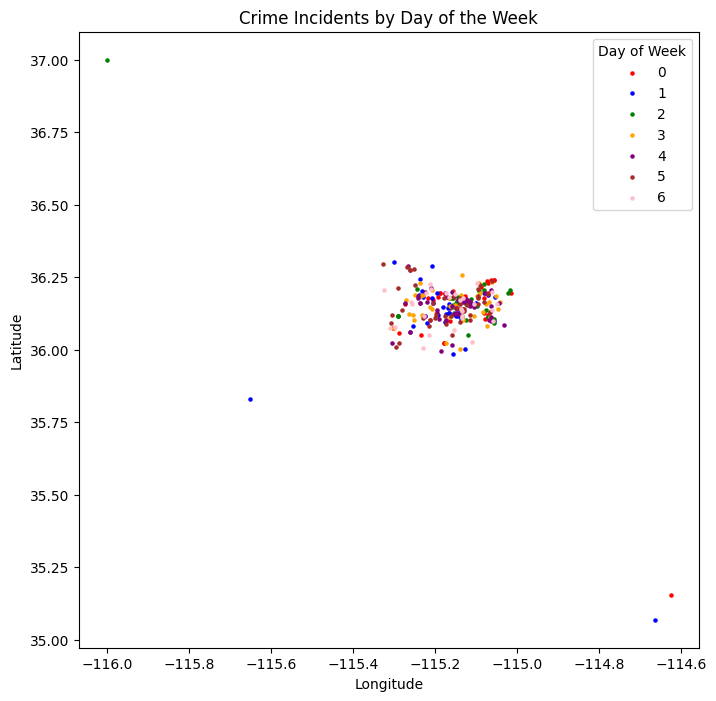

In [214]:
# Create a dictionary to map days of the week to colors
color_mapping = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown',
    6: 'pink'
}

# Create a scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
for day, color in color_mapping.items():
    day_of_week = df[df['DayOfWeek'] == day]
    plt.scatter(day_of_week['X'], day_of_week['Y'], label=day, c=color, s=5)

# Customize the plot
plt.title('Crime Incidents by Day of the Week')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Day of Week')

# Show the plot
plt.show()

I noticed that most of the crimes are happening in a small square area, that mostly represents the Las Vegas Strip / Downtown Las Vegas. The pattern seems to be that crimes happen mostly on the weekend, if we can assume that days 4-6 are the weekend.

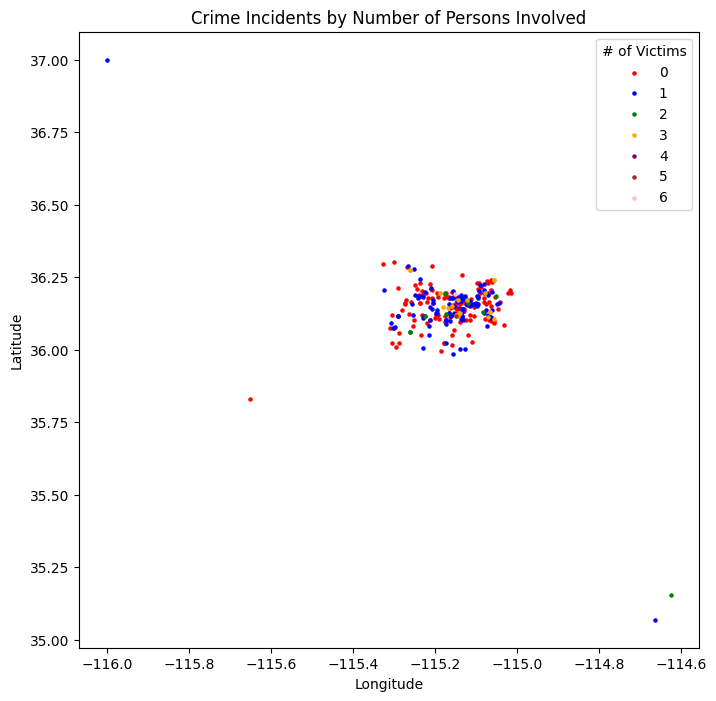

In [215]:
# Create a scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Define a custom list of colors based on 'VictimCount'
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

# Create a scatter plot with custom colors based on 'VictimCount' and add labels
for count, color in enumerate(colors):
    victim_df = df[df['VictimCount'] == count]
    plt.scatter(victim_df['X'], victim_df['Y'], label=f'{count}', c=color, s=5)

# Customize the plot for number of persons involved
plt.title('Crime Incidents by Number of Persons Involved')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='# of Victims')

plt.show()

I noticed that a lot of the crimes involve 0-1 victims.

In [216]:
# Group the data by 'DayOfWeek' and count the number of crimes for each day
day_counts = df['DayOfWeek'].value_counts().reset_index()

# Rename the columns for clarity
day_counts.columns = ['DayOfWeek', 'CrimeCount']

# Sort the data by the number of crimes in descending order
sorted_day_counts = day_counts.sort_values(by='CrimeCount', ascending=False)

# Print the result
print(sorted_day_counts.to_string(index=False))

 DayOfWeek  CrimeCount
         4          51
         3          44
         5          43
         0          40
         1          37
         2          32
         6          28


The most frequent days were Day 4 (Assuming Thursday), Day 3, and Day 5.